# Glosten-Milgrom Model for security market

## Introduction


In [1]:
%matplotlib inline
#import the needed packages
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import sympy as sm
import pandas as pd

#from local file import plotterwindow
from modelproject.plotter import PlotterWindow
from modelproject.gm_simulation import gm_simulation

#use pretty print
sm.init_printing(use_unicode=True)

## Deriving the model

we create the equation symbols needed for sympy

In [2]:
mu_t = sm.symbols("mu_t")
mu_t1 = sm.symbols("mu_t-1")
b_t = sm.symbols("b_t")
a_t = sm.symbols("a_t")
p_t = sm.symbols("P_t")
v = sm.symbols("v")
v_h = sm.symbols("v^H")
v_l = sm.symbols("v^L")
d_t = sm.symbols("d_t")
sd_t = sm.symbols("s(d_t)")
s_a = sm.symbols("s_t^a")
s_b = sm.symbols("s_t^b")
theta_t = sm.symbols("theta_t")
theta_t1 = sm.symbols("theta_t-1")
pi = sm.symbols("pi")
beta_b = sm.symbols("beta_B")
beta_s = sm.symbols("beta_S")
spib = sm.symbols("Pi_buy")
spis = sm.symbols("Pi_sell")
theta_p=sm.symbols("theta^+")
theta_m=sm.symbols("theta^-")

### Setting the model

There is a single market with 1 dealer. The dealer buys and sells a single security at the ask price $a_t$ and bid price $b_t$. In every time period t he takes a single order from a single trader. The order is denoted $d_t$ which takes the value 1 for buy order, -1 for a sale order and 0 for no order.

On the market there are two types of traders, Informed traders and liquidity traders. The informed traders have a high amount of information about the security and knows the true value of it. Further they seek to maximize their profit trading with the security, which leads to only buying if the security value higher than the ask price and only selling if the value is lower than the bid price.
Liquidity traders do not have information about the security or rather, they don’t care. These traders buys or sells the security independent on the value of the security. Among liquidity traders you find traders who either seeks to diversify their portfolio, thus buy, or who needs to liquify some assets. The liquidity trader buys with probability $\beta_B$ and sells with probability $\beta_S$.

$\pi$ share of the traders is informed traders.

On the market there is unequal information. The informed traders have private information about the value of the security. The dealer only has access to public information about the market, such as the ratio of informed traders. The dealer however receives information with each trade order. An informed trader would never sell if $a_t<v$, therefore an unequal amount of buy orders would indicate $v=v^H$


### Model equations
Before we start on our model equations, we make two assumptions:<br> i) The dealer is risk neutral and is in a competitive. <br> ii) there is no trade cost on orders on the market

To simplify our model, we set the security v to be binary distributed taking the value $v^H$ or $v^L$, the superscript denoting high and low value.

The dealer has the belief $\theta_t$, which is his estimate of the probability $p(v=v^h)=\theta$. From his belief he finds his expected value of security v denoted $\mu_t$


In [3]:
sm.Eq(mu_t,theta_t*v_h+(1-theta_t)*v_l) 

The dealer sets his ask and bid price based on his expectation to v conditional on the information $\Omega_{t-1}$ and whether he expects a buy or sell order.
$$a_t=E(v\mid \Omega_{t-1} , d_t=1)$$
$$b_t=E(v\mid \Omega_{t-1} , d_t=-1)$$
Further, since the dealer is in a competitive market, he sets the ask and bid price according to an expected null profit. Since the dealer does not know the true value of the security, he loses on every trade made with an informed trader. The deficit is made up by trading with liquidity traders. Based on his expectation to the security and his knowledge of the market, he derives the following profit functions


In [4]:
sm.Eq(theta_t1*pi*(a_t-v_h)+beta_b*(1-pi)*(a_t-mu_t1), sm.symbols("Pi^buy_t"))

In [5]:
sm.Eq((1-theta_t1)*pi*(v_l-b_t)+beta_s*(1-pi)*(mu_t1-b_t),sm.symbols("Pi^sell_t"))

From these profits he derives his optimal ask and bid price.

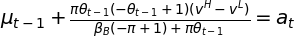

In [6]:
sm.Eq(mu_t1+(pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l), a_t)

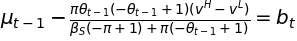

In [7]:
sm.Eq(mu_t1-(pi*theta_t1*(1-theta_t1))/(pi*(1-theta_t1)+(1-pi)*beta_s)*(v_h-v_l),b_t)

The ask and bid price equal the dealers expected value of the security with a mark-up and discount respectively. We denote the mark-up $s_t^a$ and the discount $s_t^b$

In [8]:
sm.Eq((pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l), s_a)
sm.Eq(mu_t1+s_a, a_t)

In [9]:
sm.Eq((pi*(1-theta_t1)*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_s)*(v_h-v_l), s_b)
sm.Eq(mu_t1-s_b, b_t)

Depending on the trade order the dealer receives in period t, his beliefs about the value of the security in period t+1 is changed.
$$\theta_t^{+}\equiv P(v=v^H|\Omega_{t-1},d_t=1)$$
$$\theta_t^{-}\equiv P(v=v^L|\Omega_{t-1},d_t=-1)$$

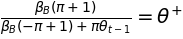

In [10]:
sm.Eq(((1+pi)*beta_b)/(pi*theta_t1+(1-pi)*beta_b),theta_p)

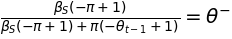

In [11]:
sm.Eq(((1-pi)*beta_s)/(pi*(1-theta_t1)+(1-pi)*beta_s),theta_m)

With his updated beliefs about the security, the dealer updates his expectation of the value of the security for the period t+1. If the dealer recieved a buy order in in period t, his expectation $\mu$ can be shown to have the following relation 
$$\mu^+_{t+1}-\mu_t=s_t^a$$
The dealer’s expectation for any order is therefore 
$$\mu_t=\mu_{t-1}+s(d_t)d_t$$
with $s(d_t)\equiv \begin{cases} s_t^a & d_t=1 \\ s_t^b & d_t=-1 \end{cases}$


## Simulating the model

Solving the multiperiod Glosten-Milgrom model is unfortunately not straight forward. The equations for the ask and bid price derived in the section Model Equations describes an equilibrium in which the informed trader maximizes his profit and the dealer ensures null profit. As seen the prices are dependent on the dealers beliefs, which are updated after each order. Due to the dynamic beliefs of the dealer, we chose to simulate the model in order to get estimates for the multiperiod equilibrium prices.

In order to simulate the Glosten-Milgrom model, we need some kind of indicator of an equilibrium. The dealer set his prices based on his information about the market and his expectation of the value of the security. In the first period the information used to set the ask and bid price is limited, which results in a rather large gap between the ask and bid price. The gap can be said to represent the dealers uncertainty about the security. The dealer he receives information about the security's value with each order placed, and based on this information he is better able to predict the value. As his uncertainty about the security is diminished, as is the price gap between ask and bid prices. A sufficient low price gap can therefore be used to indicate a multiperiod equilibrium.

Since our equilibrium indicator is based on the price gap, which in equilibrium converges on 0, we instead set a threshold value denoted $\epsilon$, at which we assume the gap to have converged to its equilibrium value. Based on our equilibrium indicator we use the following algorithm to simulate the Glosten-Milgrom model.

**How to simulate the Glosten-Milgrom model**
1. choose start values and parameters. Set threshold value $\epsilon$
2. calculate value expectation, then ask/bid price.
3. determine trader type, then order type
4. update dealer beliefs
5. repeat step 2-4 until $\epsilon > spread = a_t - b_t$

In the first step we set up all information in the model, including dealer's beliefs, ratio of informed traders, chance of uninformed placing a buy/sell order etc. We then use this information to calculate the equilibrium prices in the first period. We then determine the trader type and type of order the trader places. With this info we update the dealer's beliefs for the next period. We then calculate the next period same as the first and repeat until we reach an acceptable spread, which is lower than our threshold value.

To further dissect the algorithm we constructed a flowchart, which step by step shows how we simulate a simple Glosten-Milgrom model. The method described in the chart is the method used to construct the function gm_simulation. To ease reading the flowchart, we'll include a quick list of the variables in the model:

1. pi = $\pi$ : ratio of informermed traders on the market
2. v : the security traded on the market. taking value $v^H or v^L$
3. $\theta_t$ : dealer's beliefs about v
4. $\mu$ : dealer's expected value of v
5. $a_t$ : ask price
6. $b_t$ : bid price
7. spread = $a_t - b_t$
8. $d_t$ : order type. takes value 1 for buy, -1 for sale, 0 for no order
9. $\epsilon$ : threshold value


![Flowchart](flowchart.png) 

Based on the algorithm we made the function gm_simulation in the file gm_simulation.py in the module modelproject. With the function we are able to fully customize the Glosten-Milgrom model described in this project. Besides simulating the model, we have expanded the function to also being able to simulate an information shock on the market, which we will make use of in a later section. To get an overview of the function, we have called the docstring below.

In [12]:
help(gm_simulation)

Help on function gm_simulation in module modelproject.gm_simulation:

gm_simulation(distribution=(0, 1), decision='v_h', ratio=0.2, uninformed=0.5, startvalue=0.5, iterations=500, seed=5000, epsilon=1e-05, shockperiod=None, shock={})
    Simulates a simple Glosten-Milgrom model with binary distributed security.
    Repeats simulation until either the threshold parameter is reached or the maximum
    number of simulations is reached.
    
    Args:
        distribution (tuple): upper and lower value for the security. Default (0,1)
        decision (string): selecting the true value of the security. Default "v_h". options = ("v_h", "v_l")
        
        ratio (float): Ratio of informed traders on the market. Default 0.2
        uninformed (float): Chance to receieve buy order from uninformed trader. Default 0.5
        startvalue (float): Dealer's start belief about the value of the security. Default 0.5
        
        iterations (int): Maximum number of iterations run by the simulat

The gm_simulation function depends on several random distributions when simulating the model. Our results are therefore heavily influenced by the draw. To properly demonstrate this feature we run the gm_simulation function 5 times with different seeds and plot the development in the dealer's beliefs $\theta_t$.

Text(0.5, 1.0, 'Theta')

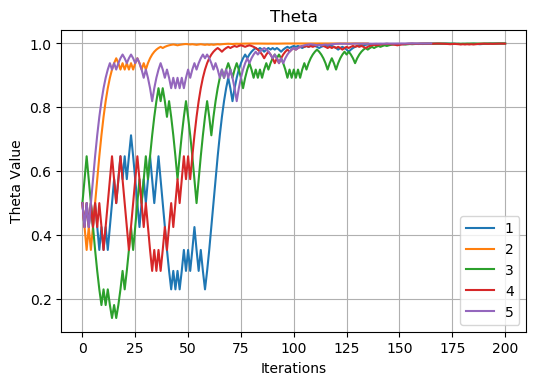

In [13]:
#calling gm_simulation function with different seeds. 
thetarun1 = gm_simulation(ratio=0.15, iterations=201,seed=4795)
thetarun2 = gm_simulation(ratio=0.15, iterations=201,seed=6279)
thetarun3 = gm_simulation(ratio=0.15, iterations=201,seed=6130)
thetarun4 = gm_simulation(ratio=0.15, iterations=201,seed=9352)
thetarun5 = gm_simulation(ratio=0.15, iterations=201,seed=5059)

#saving the returned data
thetadata1, thetavalues1 = thetarun1
thetadata2, thetavalues2 = thetarun2
thetadata3, thetavalues3 = thetarun3
thetadata4, thetavalues4 = thetarun4
thetadata5, thetavalues5 = thetarun5

#plotting the theta data from the simulations
fig = plt.figure(dpi=100)
ax2 = fig.add_subplot(1,1,1)
ax2.plot(thetadata1["theta"], label="1")
ax2.plot(thetadata2["theta"], label="2")
ax2.plot(thetadata3["theta"], label="3")
ax2.plot(thetadata4["theta"], label="4")
ax2.plot(thetadata5["theta"], label="5")
ax2.grid(True)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Theta Value")
ax2.legend()
ax2.set_title("Theta")

As we can see in the graph above, all the simulations converge towards the same long term equilibrium. The speed of convergence however is vastly different for the different seeds. This inconsistency in convergence could lead to misleading results for the equilibrium values, especially for lower values of $\pi$

In order to get more credible results for the equilibrium values, we create the function numericalsolution, which loops the gm_simulation function N times with random seeds and output the mean values for the N different equilibria. For a sufficiently large N the results converge to an symptotic distribution, which yields more credible results for the equilibrium values.

In [14]:
def numericalsolution(N=1000, ratio=0.15):
    """Runs the gm_simulation N number of times with different seeds. 
    
    Args:
        N (int): number of runs. Default 1000
        ratio (float): ratio of informed traders used in gm_simulation. Default 0.15.
    
    Returns:
        Meanvalues (dict): mean of the values dictionaries returned by gm_simulation
    """
    data = pd.DataFrame()
    
    for i in range(N):
        seed = int(np.random.uniform(0,10000))
        dataframe, values = gm_simulation(distribution=(0,10), ratio=ratio, startvalue=0.5, 
                                          iterations = 1001, seed=seed, epsilon=5**-5)
        
        for key in values:
            data.loc[i,key]=values[key]
            
    meanvalues = {}
    for key in list(data.columns):
        meanvalues[key]=data[key].mean()
    return meanvalues

Below we call the function with default values. It should be noted the function is rather computation heavy as the gm_simulation with $\pi=0.15$ runs an average 216 iterations, and the numerical solution runs the gm_simulation 1000 times.

In [15]:
%time numericalsolution()

Wall time: 9.54 s


{'Theta': 0.9999543796226845,
 'Bid': 9.99937042512405,
 'Ask': 9.999656044732731,
 'Mu': 9.999534654405569,
 'Equilibrium period': 217.62}

With a ratio 0.15 we reach equilibrium after 216 iterations on average. Note results may vary a bit if running the function. As expected, $\theta_t$ converges towards 1, while ask price, bid price and expected value $\mu$ converges towards the true value of the security.

In order to examine the influence of the ratio of traders, we construct a for loop to run numericalsolution for every $\pi$ value in the range $[0.01;1]$.

The code below is extremely slow due to the amount of computations needed to perform the task. The first couple of $\pi$ values do not converge to an equilibrium within 1000 iterations. The first 5 values require a total of 5 million iterations of the gm_simulation loop. Due to the high computation requirement we added a faulty line of code to prevent you from accidently running the code. If you wish to run the code, comment out the line: import PreventYouFromRunning.

We have run the code and saved the data from that run in the file doomloopdata.csv. The code below is included to show how we got the results in the file. We do not advise you to run the code

In [16]:
#To prevent you from accidently running it we have include the line below.
import PreventYouFromRunning

#make lists
ratiolist = []
periodlist = []

#loop the function numericalsolution
for i in range(99):
    num = ((i+1)/100)
    values = numericalsolution(ratio=num)
    
    ratiolist.append(num)
    periodlist.append(values["Equilibrium period"])


ModuleNotFoundError: No module named 'PreventYouFromRunning'

With the data from the doomloopdata.csv we create a plot which shows the correlation between the ratio of informed traders $\pi$ and the equilibrium period. We have included commented out code to create the plot with data from the loop above, if you ran it. Else the graph is created from the doomloopdata.csv file.

Text(0, 0.5, 'Period')

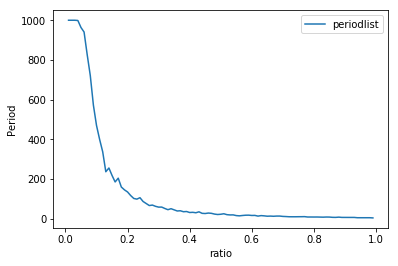

In [17]:
#if you ran the above code, uncomment the three lines below to graph the data
#plt.plot(ratiolist,periodlist)
#plt.xlabel("ratio")
#plt.ylabel("Period")

#alternative:
#read data file
doomloopdata = pd.read_csv("./doomloopdata.csv")
doomloopdata.columns = ["periodlist","ratiolist"]

#plot the data
doomloopdata.plot("ratiolist","periodlist")
plt.xlabel("ratio")
plt.ylabel("Period")

The speed of convergence towards the equilibrium is heavily determined by the ratio of informed traders. For higher values of $\pi$ the amount of information in the trade flow is higher. The dealer therefore received less noise about the security's true value, which results in a faster convergence towards the equilibrium prices. 

### Initial expectation

In this section we examine the effect of the dealer's initial belief. 

We call the gm_simulation for different values of $\pi$ and plot bid price, ask price and expected value $\mu_t$ in our custom interactive graphwindow class. In the graph window you are able move around in the plot and examine the development of the model for different $\pi$ values


In [18]:
#call gm_simulation function 5 times with different ratios
startrun1 = gm_simulation(startvalue = 0.10, ratio=0.13, iterations=1001, seed=404)
startrun2 = gm_simulation(startvalue = 0.15, ratio=0.13, iterations=1001, seed=404)
startrun3 = gm_simulation(startvalue = 0.25, ratio=0.13, iterations=1001, seed=404)
startrun4 = gm_simulation(startvalue = 0.5, ratio=0.13, iterations=1001, seed=404)
startrun5 = gm_simulation(startvalue = 0.8, ratio=0.13, iterations=1001, seed=404)

#save data
startrundata1, startrunvalues1 = startrun1
startrundata2, startrunvalues2 = startrun2
startrundata3, startrunvalues3 = startrun3 
startrundata4, startrunvalues4 = startrun4
startrundata5, startrunvalues5 = startrun5

#merge data
startrunmerged = pd.concat([startrundata1, startrundata2, startrundata3, startrundata4, startrundata5])

By plotting the ask price $a_t$, bid price $b_t$ and the expected value of the security $\mu$ the path to equilibrium is clearly shown. Convergence in the bid-ask spread, which is used as our equilibrium indicator, can clearly be seen from such a plot.

In order to give an optimal view of our simulation results we make use of a custom module plotter, which renders an interactive graph window. The plotter module used in this project is a repurposed version of the module we developed as a part of our dataproject. One of the major features of the PlotterWindow is the toolbar, which allows you to zoom in/out and move around the graph. We encourage you to make use of this feature to get a better picture of the data.

It should be noted on some python installations the graph window does not take screen priority over the notebook and will hide behind it. A simple alt-tab or command-tab should bring it to the front.

In [19]:
#call custom graphwindow class with graphtype=piplot
startrungraphwindow = PlotterWindow(data = startrunmerged, slicename = "startvalue", xvariable = "Iteration", 
                                    yvariablelist = ["mu","ask","bid"], graphtype ="piplot")
startrungraphwindow.start()

As seen in the PlotterWindow the convergence for our startrun simulations is rather rapid at first with all getting close to the value 1. There is however some instability and divergence for most graphs, especially around iterations 450-500. The graphs with a lower startvalue shows a more volatile behaviour and a slower convergence on the equilibrium. The higher values, which for these simulations are better start predictions, shows less volatility and faster convergence. The better information about the security the dealer has access to in the first period, the faster convergence do the market have towards optimal prices.

Below we perform the simulation again though with the difference of the security taking the low value $v^L$ as to proporly show the conclusion on the startvalues influence.

In order to better show the bid-ask spread, we make use of a different graphtype from the PlotterWindow class. We use the PlotterWindow to make a candlestick graph. The vertical bars in the candlestick graphs represent the ask-bid spread.

In [20]:
#call gm_simulation function 5 times with different ratios
startlowrun1 = gm_simulation(decision = "v_l", startvalue = 0.10, ratio=0.13, iterations=1001, seed=2009)
startlowrun2 = gm_simulation(decision = "v_l", startvalue = 0.15, ratio=0.13, iterations=1001, seed=2009)
startlowrun3 = gm_simulation(decision = "v_l", startvalue = 0.25, ratio=0.13, iterations=1001, seed=2009)
startlowrun4 = gm_simulation(decision = "v_l", startvalue = 0.5, ratio=0.13, iterations=1001, seed=2009)
startlowrun5 = gm_simulation(decision = "v_l", startvalue = 0.8, ratio=0.13, iterations=1001, seed=2009)

#save data
startlowrundata1, startlowrunvalues1 = startlowrun1
startlowrundata2, startlowrunvalues2 = startlowrun2
startlowrundata3, startlowrunvalues3 = startlowrun3 
startlowrundata4, startlowrunvalues4 = startlowrun4
startlowrundata5, startlowrunvalues5 = startlowrun5

#merge data
startlowrunmerged = pd.concat([startlowrundata1, startlowrundata2, startlowrundata3, startlowrundata4, startlowrundata5])

#call custom graphwindow class with graphtype=candlestick
startlowrungraphwindow2 = PlotterWindow(data = startlowrunmerged, slicename = "startvalue", graphtype = "candlestick")
startlowrungraphwindow2.start()

With the low value $v^L$ we have faster convergence in general towards equilibrium compared to the high value $v^H$ simulations. The conclusions about the initial prediction is however the same. The better informed the dealer is in the first period the faster convergence on the optimal prices.

## Shocks to the model

To further examine the model we make use of the built-in shock options in the gm_simulation function. We introduce several types of shocks to the market and graph the results with the PlotterWindow. In the interest of getting credible results we would have preferred to use a slightly modified version of the numericalsolution function. We however chose to use the less reliable gm_simulation instead due to the lower amount of computational power needed.

We simulate our model with three different types of shocks. 
1. The first shock is a shock in private information. We change the realisation of the variable v from $v^H$ to $v^L$. This information is only available to the informed traders, who know the true value of the security. A real-life example of this type of shock would be a trader receiving insider info from a firm.
2. The second shock is a public information shock. We change the upper and lower value for v from (0,1) to (0.3, 0.8). This information is available to all participants on the market. A real-life example of this type of shock would be the release of the annual report from a firm
3. We apply both types of shock to the model..

all of the shocks incur in the 90th period. To avoid naming conflict in our graphwindow we set a slightly different ratio $\pi$ for the different simulation. The difference on the results have been tested and found to be negligible.

In [21]:
#call gm_simulation function with different shock types
shockrun1 = gm_simulation(ratio=0.15001, iterations=1001, seed=404, shockperiod = 90, shock={"Private":0})
shockrun2 = gm_simulation(ratio=0.15002, iterations=1001, seed=404, shockperiod = 90, shock={"Public":(0.3, 0.8)})
shockrun3 = gm_simulation(ratio=0.15003, iterations=1001, seed=404, shockperiod = 90, shock={"Private":0, "Public":(0.3,0.8)})

#save results
shockdata1, shockvalues1 = shockrun1
shockdata2, shockvalues2 = shockrun2
shockdata3, shockvalues3 = shockrun3

#merge results
shockmerged = pd.concat([shockdata1,shockdata2,shockdata3])

#call custom graphwindow class with graphtype = piplot
shockgraphwindow = PlotterWindow(data = shockmerged, slicename = "ratio", xvariable = "Iteration", yvariablelist = ["mu","ask","bid"], graphtype="piplot")
shockgraphwindow.start()

From the graphs we find the following
1. Private information: shock After the shock the model slowly converges towards the new equilibrium, which is at $a_t, b_t, \mu_t \rightarrow v^L$. The dealer slowly receives information about the new equilibrium from the informed traders’ behaviour. He adjusts his ask and bid price to make up for the new informed trader strategy.
2. Public information: The change in the prices happens instantly when the new information is made available. This behaviour on the market suggests our model is semi-strong form efficient, since the market instantly adepts to the new public information.
3. Both: With both shock types we see the instant response to the public information. The reaction to the private information shock is rather slow, as with the first graph.

The Glosten-Milgrom model is capable of adapting to the different information shocks and converges on the equilibrium for all simulations.

# Conclusion

In this paper we found the Gloston-milgrom model capable of adapting to public and private information. The model simulated the behaviour of several types of traders and a market maker (the dealer) and showed their adaptions to the information available. The model further shows this adaptation of information by the equilibrium prices converging on the true value of the security <br>
The ratio of informed traders $\pi$ on the market have a huge impact on the speed of convergence and spread of ask and bid prices. <br>
From the shocks we introduce to the model we conclude the model is semi-strong form efficient.